# 개체명 인식(Named Entity Recognition)


* 개체명 인식은 텍스트에서 이름을 가진 개체를 인식하는 기술      
* 가령, '철수와 영희는 밥을 먹었다'에서 이름과 사물을 추출하는 개체명 인식 모델 결과

  철수 - 이름    
  영희 - 이름    
  밥 - 사물

## 개체명 인식 - NLTK

* https://wikidocs.net/30682

* `nltk` 라이브러리에서는 미리 학습된 개체명 인식 모델을 제공

### 라이브러리 준비

In [1]:
import nltk

nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


True

### 토큰화 및 품사 태깅

In [2]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = "James is working at Disney in London"
sentence = pos_tag(word_tokenize(sentence))
print(sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


### 개체명 인식

In [3]:
sentence = ne_chunk(sentence)

print(sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


## 개체명 인식 - LSTM

* https://wikidocs.net/24682

* 사용자가 제공되고 있는 개체명 인식 모델과는 다른 개체명을 정의해 사용하는 것이 필요할 수 있음
* 직접 개체명 인식 모델을 구성해 학습하고 사용할 수 있음

### 라이브러리 준비

In [4]:
import numpy as np
import urllib.request

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### 데이터 준비

* 공개된 개체명 인식 데이터셋을 이용
  + https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt
* 해당 데이터는 단어-개체명 형식으로 이루어져 있으므로 이를 가공해 데이터셋을 생성

In [5]:
tagged_sentences = []
sentence = []

with urllib.request.urlopen('https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt') as f:
    for line in f:
        line = line.decode('utf-8')
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":  # 문장 구분
            if len(sentence) > 0:
                tagged_sentences.append(sentence)
                sentence = [] # 초기화
            continue
        splits = line.strip().split(' ')
        word = splits[0].lower()
        sentence.append([word, splits[-1]])

print(len(tagged_sentences))
print(tagged_sentences[0])

14041
[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


### 데이터 전처리

* 단어와 개체명 태그를 분리해서 데이터를 구성

In [6]:
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

* 정제 및 빈도 수가 높은 상위 단어들만 추출하기 위해 토큰화 작업

In [7]:
max_words = 4000
src_tokenizer = Tokenizer(num_words = max_words, oov_token = 'OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [8]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) +1

print(vocab_size)
print(tag_size)

4000
10


* 데이터를 학습에 활용하기 위해 데이터를 배열로 변환
* 해당 작업은 토큰화 툴의 `texts_to_sequences()`를 통해 수행

In [32]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

* 학습에 투입할 때는 동일한 길이를 가져야 하므로, 지정해둔 최대 길이에 맞춰 모든 데이터를 동일한 길이로 맞춰줌
* 일반적으로 길이를 맞출 때는 모자란 길이만큼 0을 추가


In [33]:
max_len = 70
X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
y_train = pad_sequences(y_train, padding = 'post', maxlen = max_len)

* 훈련, 실험 데이터 분리 및 원 핫 인코딩을 시행

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = .2, random_state = 123)

y_train = to_categorical(y_train, num_classes = tag_size)
y_test = to_categorical(y_test, num_classes = tag_size)

* 최종적으로 생성된 데이터셋의 크기는 다음과 같음

In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11232, 70)
(11232, 70, 10)
(2809, 70)
(2809, 70, 10)


### 모델 구축 및 학습

* 모델 구축에는 `keras`를 이용
* 해당 작업에 필요한 함수들을 추가로 import

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
 # from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

모델의 구성

1. 입력을 실수 벡터로 임베딩
2. 양방향 LSTM 구성
3. Dense layer를 통한 각 태그에 속할 확률 예측

`TimeDistributed`는 상위 layer의 출력이 step에 따라 여러 개로 출력되어 이를 적절하게 분배해주는 역할

In [37]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 128, input_length = max_len, mask_zero = True))
model.add(Bidirectional(LSTM(256, return_sequences = True)))
model.add(TimeDistributed(Dense(tag_size, activation = 'softmax')))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 128)           512000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 70, 512)           788480    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 70, 10)            5130      
 stributed)                                                      
                                                                 
Total params: 1305610 (4.98 MB)
Trainable params: 1305610 (4.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* 모델 컴파일 및 학습 진행, 평가

In [38]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(0.001),
              metrics = ['accuracy'])

history = model.fit(X_train, y_train, batch_size = 128, epochs = 5, validation_data = (X_test, y_test))

Epoch 1/5
88/88 [==============================] - 22s 143ms/step - loss: 0.8831 - accuracy: 0.8234 - val_loss: 0.5727 - val_accuracy: 0.8373
Epoch 2/5
88/88 [==============================] - 5s 58ms/step - loss: 0.4530 - accuracy: 0.8594 - val_loss: 0.3660 - val_accuracy: 0.8881
Epoch 3/5
88/88 [==============================] - 5s 53ms/step - loss: 0.3032 - accuracy: 0.9085 - val_loss: 0.2597 - val_accuracy: 0.9256
Epoch 4/5
88/88 [==============================] - 3s 29ms/step - loss: 0.2173 - accuracy: 0.9362 - val_loss: 0.2075 - val_accuracy: 0.9418
Epoch 5/5
88/88 [==============================] - 3s 31ms/step - loss: 0.1644 - accuracy: 0.9521 - val_loss: 0.1780 - val_accuracy: 0.9518


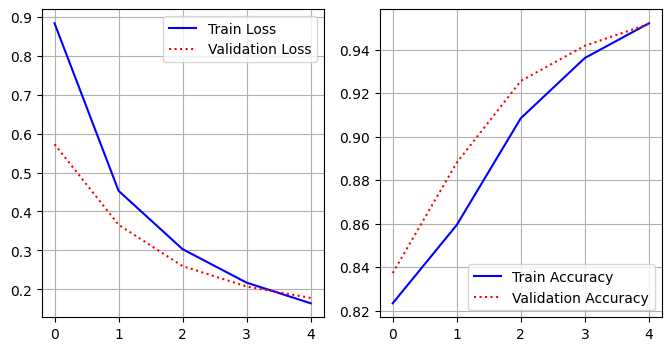

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r:', label='Validation Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r:', label='Validation Accuracy')
plt.legend()
plt.grid();

In [42]:
model.evaluate(X_test, y_test)

88/88 [==============================] - 1s 7ms/step - loss: 0.1768 - accuracy: 0.9518


[0.1768101304769516, 0.9518169164657593]

### 학습한 모델을 통한 예측

* 예측을 확인하기 위해서 인덱스를 단어로 변환해줄 사전이 필요
* 사전은 토큰화 툴의 사전을 이용

In [43]:
idx2word = src_tokenizer.index_word
idx2ner = tar_tokenizer.index_word
idx2ner[0] = 'PAD'

In [44]:
idx2ner

{1: 'o',
 2: 'b-loc',
 3: 'b-per',
 4: 'b-org',
 5: 'i-per',
 6: 'i-org',
 7: 'b-misc',
 8: 'i-loc',
 9: 'i-misc',
 0: 'PAD'}

* 예측 시각화

In [50]:
#예측 시각화
n=23
y_pred = model.predict(np.array([X_test[n]]))
y_pred = np.argmax(y_pred, axis=-1)
true = np.argmax(y_test[n], -1)

print('{:15}|{:5}|{}'.format('단어', '실제값', '예측값'))
print('-'*40)

for w, t, pred in zip(X_test[n], true, y_pred[0]):
    if w != 0:
        print('{:17}|{:7}|{}'.format(idx2word[w], idx2ner[t].upper(), idx2ner[pred].upper()))

1/1 [==============================] - 0s 30ms/step
단어             |실제값  |예측값
----------------------------------------
14               |O      |O
-                |O      |O
barbara          |B-PER  |B-PER
OOV              |I-PER  |I-PER
(                |O      |O
austria          |B-LOC  |B-LOC
)                |O      |O
beat             |O      |O
OOV              |B-PER  |B-PER
OOV              |I-PER  |I-PER
(                |O      |O
china            |B-LOC  |B-LOC
)                |O      |O
6-2              |O      |O
6-1              |O      |O
